# Unphased Data Results

Summary stats for Lin Reg (Unphased):
        R2 Score  IQS Score  Accuracy Score  AUC Score
count  22.000000  22.000000       22.000000  22.000000
mean    0.622296   0.827436        0.893280   0.857419
std     0.115266   0.046574        0.033250   0.057703
min     0.398726   0.731621        0.819095   0.687836
25%     0.557515   0.802500        0.877003   0.845340
50%     0.626345   0.823748        0.885236   0.865303
75%     0.673236   0.850117        0.914970   0.890535
max     0.855734   0.909234        0.953870   0.949132
Summary stats for Log Reg (Phased):
        R2 Score  IQS Score   Accuracy    AUC ROC
count  22.000000  22.000000  22.000000  22.000000
mean    0.710370   0.884326   0.951146   0.985096
std     0.111678   0.040605   0.017963   0.007352
min     0.427864   0.806573   0.910978   0.969594
25%     0.640933   0.849980   0.939407   0.980259
50%     0.729609   0.888036   0.950399   0.987171
75%     0.795682   0.911873   0.962439   0.990725
max     0.873255   0.955689   0

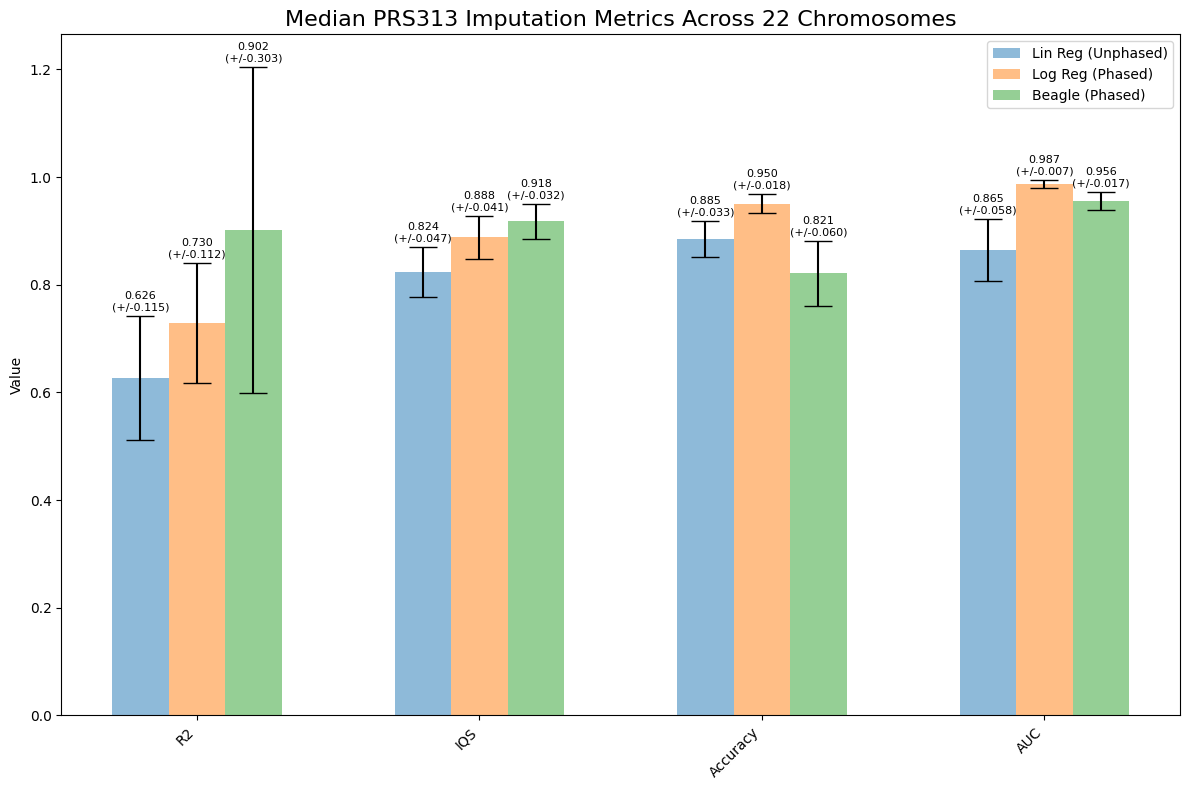

In [54]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

def read_csv_files(folder_path):
    return [pd.read_csv(os.path.join(folder_path, file_name)) 
            for file_name in os.listdir(folder_path) if file_name.endswith(".csv")]

def combine_dataframes(dataframes):
    return pd.concat(dataframes, ignore_index=True).dropna().drop(columns='Chromosome')

def calculate_summary_stats(df):
    return df.describe()

def extract_metrics(summary_stats):
    return summary_stats.loc['50%'].values, summary_stats.loc['std'].values

def plot_metrics(metrics, model_medians, model_std_devs, model_names):
    fig, ax = plt.subplots(figsize=(12, 8))
    x = range(len(metrics))
    width = 0.2  # the width of the bars

    for i, (medians, std_devs) in enumerate(zip(model_medians, model_std_devs)):
        bar_positions = [p + i * width for p in x]
        ax.bar(bar_positions, medians, width=width, yerr=std_devs, align='center', alpha=0.5, ecolor='black', capsize=10, label=model_names[i])
        
        for j, (median, std_dev) in enumerate(zip(medians, std_devs)):
            # Stagger the label positions to avoid overlap
            offset = (i % 2) * 0.0  # stagger by 0.1
            ax.text(bar_positions[j], median + std_dev + 0.01 + offset, f"{median:.3f}\n(+/-{std_dev:.3f})", ha='center', fontsize=8)

    ax.set_xticks([p + width * (len(model_names) - 1) / 2 for p in x])
    ax.set_xticklabels(metrics, rotation=45, ha='right')
    ax.set_ylabel('Value')
    ax.set_title('Median PRS313 Imputation Metrics Across 22 Chromosomes', fontsize=16)
    ax.legend()

    fig.tight_layout()
    plt.show()

def visualize_performance(model_paths):
    metrics = ['R2', "IQS", "Accuracy", "AUC"]
    
    model_medians = []
    model_std_devs = []
    model_names = []
    
    for model_name, folder_path in model_paths.items():
        dataframes = read_csv_files(folder_path)
        combined_df = combine_dataframes(dataframes)
        summary_stats = calculate_summary_stats(combined_df)
        medians, std_devs = extract_metrics(summary_stats)
        
        print(f"Summary stats for {model_name}:")
        print(summary_stats)
        
        model_medians.append(medians)
        model_std_devs.append(std_devs)
        model_names.append(model_name)
    
    plot_metrics(metrics, model_medians, model_std_devs, model_names)

# Example usage:
model_paths = {
    "Lin Reg (Unphased)": "../../../Data/model_results_unphased_all_PRS/linear_regression/csv_files",
    "Log Reg (Phased)": "../../../Data/model_results/logistic_regression/csv_files",

    "Beagle (Phased)": "../../../Data/model_results_unphased_all_PRS/beagle/csv_files"
}

visualize_performance(model_paths)


/Users/gea2/Documents/medicaid/DeepImpute/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 9.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


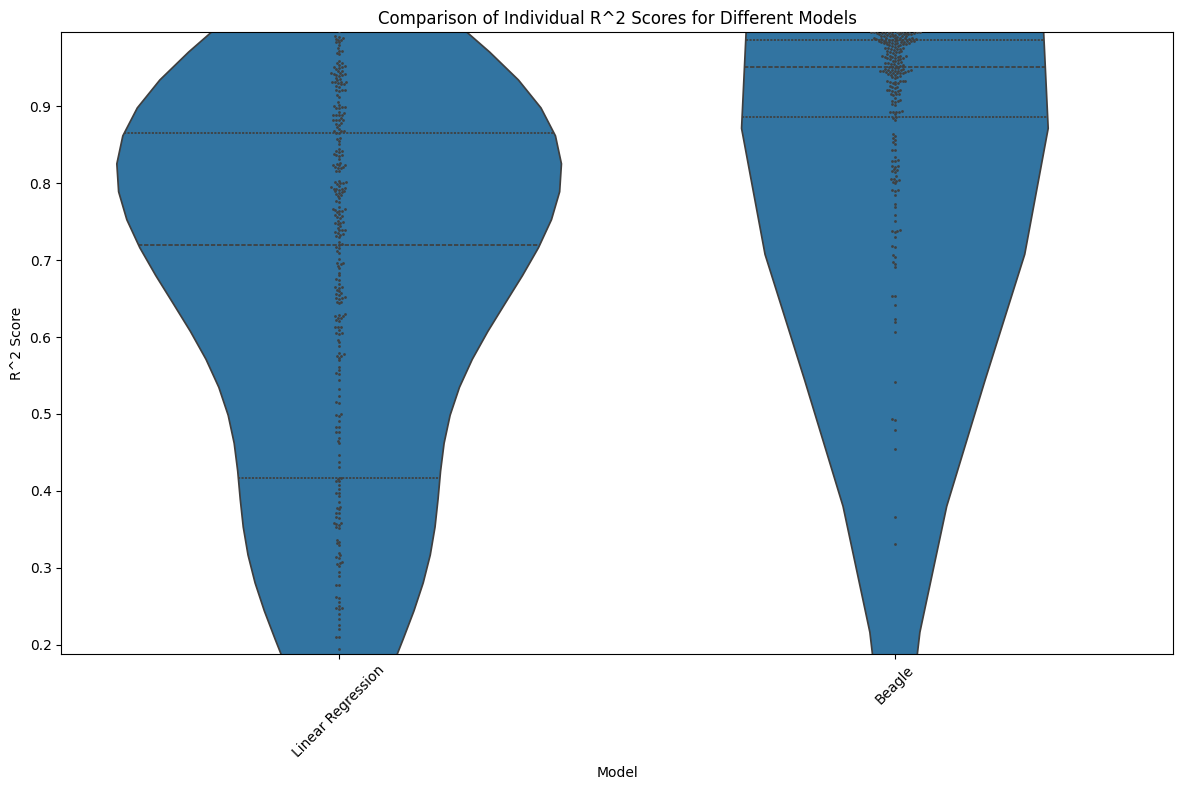

In [61]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def load_individual_r2_scores(paths, model_names):
    r2_scores = {}
    for path, model_name in zip(paths, model_names):
        r2_scores[model_name] = []
        for chrom_dir in sorted(os.listdir(path)):
            chrom_path = os.path.join(path, chrom_dir)
            if os.path.isdir(chrom_path):
                for file in os.listdir(chrom_path):
                    if file.startswith('individual_r2_scores') and file.endswith('.csv'):
                        file_path = os.path.join(chrom_path, file)
                        df = pd.read_csv(file_path)
                        df['Model'] = model_name
                        r2_scores[model_name].append(df)
    return r2_scores

def combine_r2_scores(r2_scores):
    combined_df = pd.DataFrame()
    for model_name, dfs in r2_scores.items():
        for df in dfs:
            combined_df = pd.concat([combined_df, df], ignore_index=True)
    return combined_df

def create_violin_plots(combined_df):
    # Use a modern style
    sns.set(style="whitegrid", palette="muted")
    plt.figure(figsize=(14, 10))

    # Create the violin plot
    sns.violinplot(x='Model', y='R2 Score', data=combined_df, inner='quartile', linewidth=1.25)

    # Overlay swarm plot
    sns.swarmplot(x='Model', y='R2 Score', data=combined_df, color=".3", size=3)

    # Set titles and labels
    plt.title('Comparison of Individual R^2 Scores for Different Models', fontsize=18, weight='bold')
    plt.xlabel('Model', fontsize=14)
    plt.ylabel('R^2 Score', fontsize=14)

    # Customize ticks
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)

    # Customize gridlines
    plt.grid(True, linestyle='--', alpha=0.7)

    # Adjust the y-axis limit if needed
    plt.ylim([combined_df['R2 Score'].quantile(0.05), combined_df['R2 Score'].quantile(0.95)])

    # Add legend if necessary (example placeholder, adjust as needed)
    # plt.legend(title='Legend Title', title_fontsize='13', loc='upper left', fontsize='11')

    plt.tight_layout()
    plt.show()

# Example usage
paths = [
    '../../../Data/model_results_unphased_all_PRS/linear_regression/csv_files',
    '../../../Data/model_results_unphased_all_PRS/beagle/csv_files'
]
model_names = ['Linear Regression', 'Beagle']  # Corresponding model names for the paths

r2_scores = load_individual_r2_scores(paths, model_names)
combined_df = combine_r2_scores(r2_scores)
create_violin_plots(combined_df)


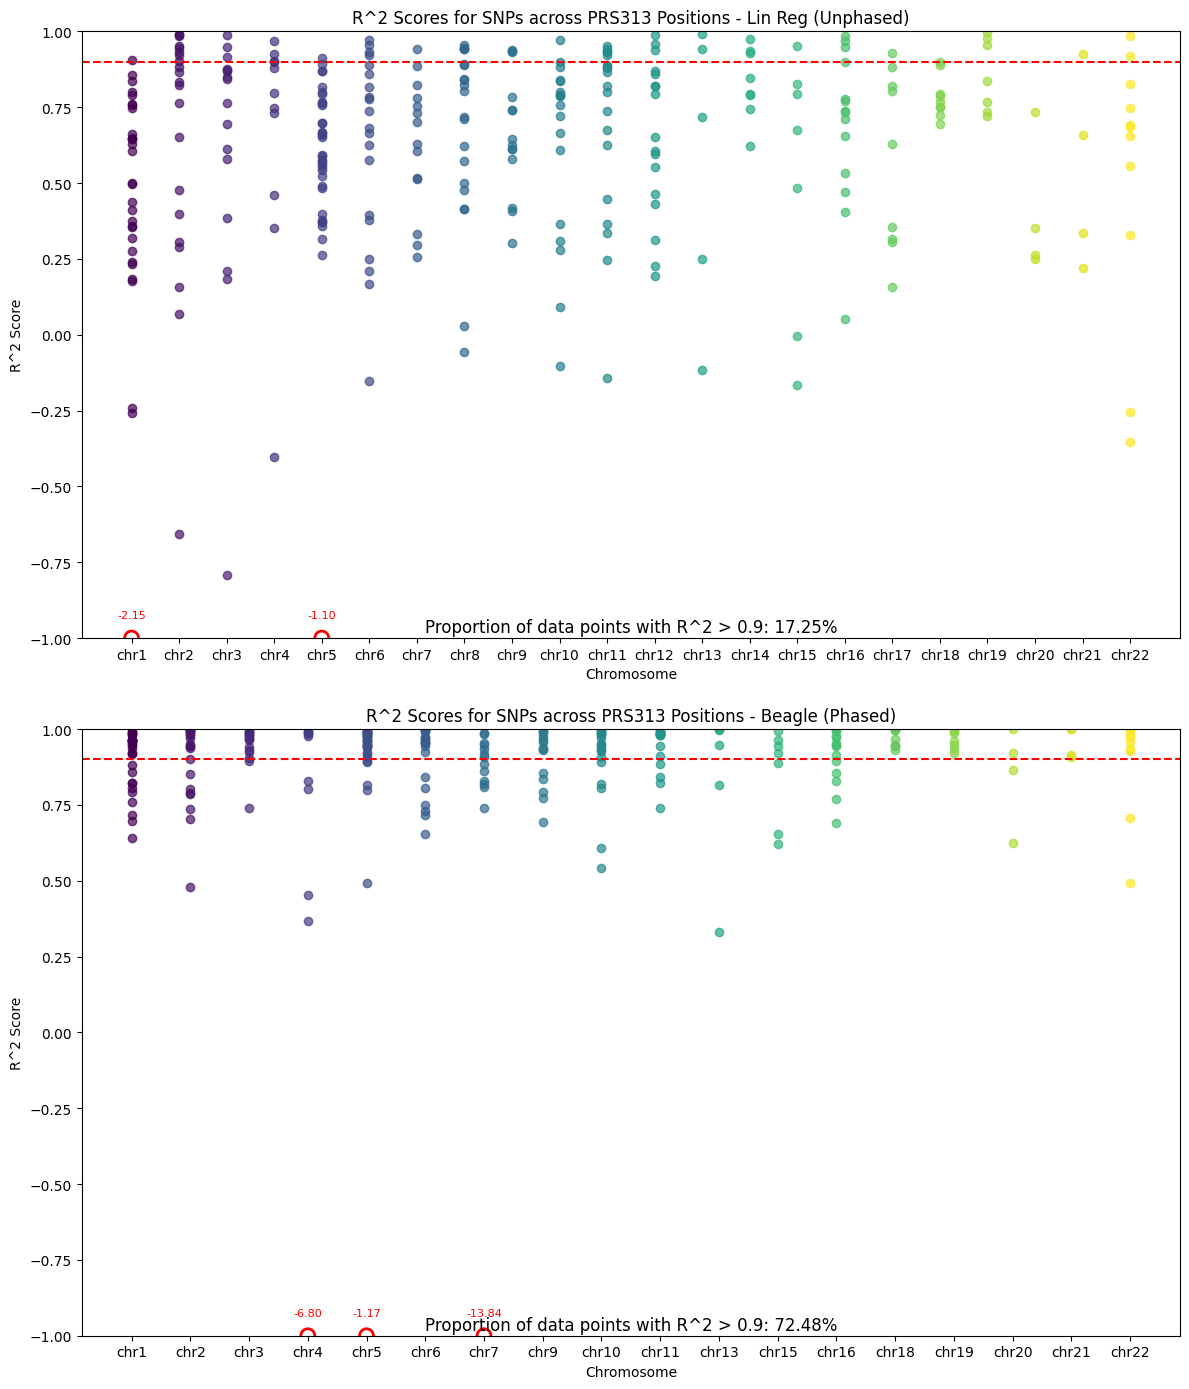

In [51]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from functools import partial

# Define a function to read and process CSV file
def read_and_process_csv(base_dir, chr_folder):
    csv_file = os.path.join(base_dir, chr_folder, f'individual_r2_scores_{chr_folder}.csv')
    df = pd.read_csv(csv_file)
    df[['chromosome', 'position']] = df['SNP'].str.split('_', n=2, expand=True)[[0, 1]]
    df['position'] = pd.to_numeric(df['position'])
    return df

# Define a function to plot data
def plot_data(ax, cmap, i, df, chr_folder, label_prefix):
    df['x'] = i
    main_data = df[(df['R2 Score'] >= -1) & (df['R2 Score'] <= 1)]
    outliers = df[(df['R2 Score'] < -1) | (df['R2 Score'] > 1)]

    # Plot main data points
    ax.scatter(main_data['x'], main_data['R2 Score'], label=f"{label_prefix} {chr_folder}", color=cmap(i), alpha=0.7)

    # Highlight outliers
    offset_x = 0  # Adjust the x offset for the annotation
    offset_y = -0.075  # Adjust the y offset for the annotation
    for _, outlier in outliers.iterrows():
        y_position = -1 if outlier['R2 Score'] < -1 else 1
        ax.scatter(outlier['x'], y_position, color=cmap(i), edgecolor='red', s=100, linewidth=2, facecolor='none')
        ax.text(outlier['x'] + offset_x, y_position + offset_y * (1 if y_position == 1 else -1), f"{outlier['R2 Score']:.2f}", color='red', fontsize=8, ha='center', va='center')

    return (df['R2 Score'] > 0.9).sum(), len(df)

# Define a function to create the plot
def create_plot_r2(base_dir, model_name, ax, label_prefix):
    chr_folders = sorted(
        (folder for folder in os.listdir(base_dir) if folder.startswith('chr')),
        key=lambda x: int(x[3:])
    )
    
    cmap = plt.get_cmap('viridis', len(chr_folders))

    process_folder = partial(read_and_process_csv, base_dir)
    results = [
        plot_data(ax, cmap, i, process_folder(chr_folder), chr_folder, label_prefix) 
        for i, chr_folder in enumerate(chr_folders)
    ]

    data_points_above_threshold, total_data_points = map(sum, zip(*results))
    proportion = data_points_above_threshold / total_data_points

    ax.axhline(y=0.9, color='red', linestyle='--', linewidth=1.5)
    ax.set_title(f'R^2 Scores for SNPs across PRS313 Positions - {model_name}')
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('R^2 Score')
    ax.set_xticks(range(len(chr_folders)))
    ax.set_xticklabels(chr_folders)
    ax.set_ylim(-1, 1)
    ax.text(0.5, 0.01, f'Proportion of data points with R^2 > 0.9: {proportion:.2%}', transform=ax.transAxes, fontsize=12, ha='center')

# Define a function to plot the comparison
def plot_comparison(base_dir_1, model_name_1, base_dir_2, model_name_2):
    fig, axs = plt.subplots(2, 1, figsize=(12, 14))

    create_plot_r2(base_dir_1, model_name_1, axs[0], 'Model 1')
    create_plot_r2(base_dir_2, model_name_2, axs[1], 'Model 2')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.15)  # Adjust this value to increase spacing between the plots
    plt.show()

# Define the base directory paths and model names
base_dir_1 = "../../../Data/model_results_unphased_all_PRS/linear_regression/csv_files"
model_name_1 = "Lin Reg (Unphased)"

base_dir_2 = "../../../Data/model_results_unphased_all_PRS/beagle/csv_files"
model_name_2 = "Beagle (Phased)"

# Create the comparison plot
plot_comparison(base_dir_1, model_name_1, base_dir_2, model_name_2)


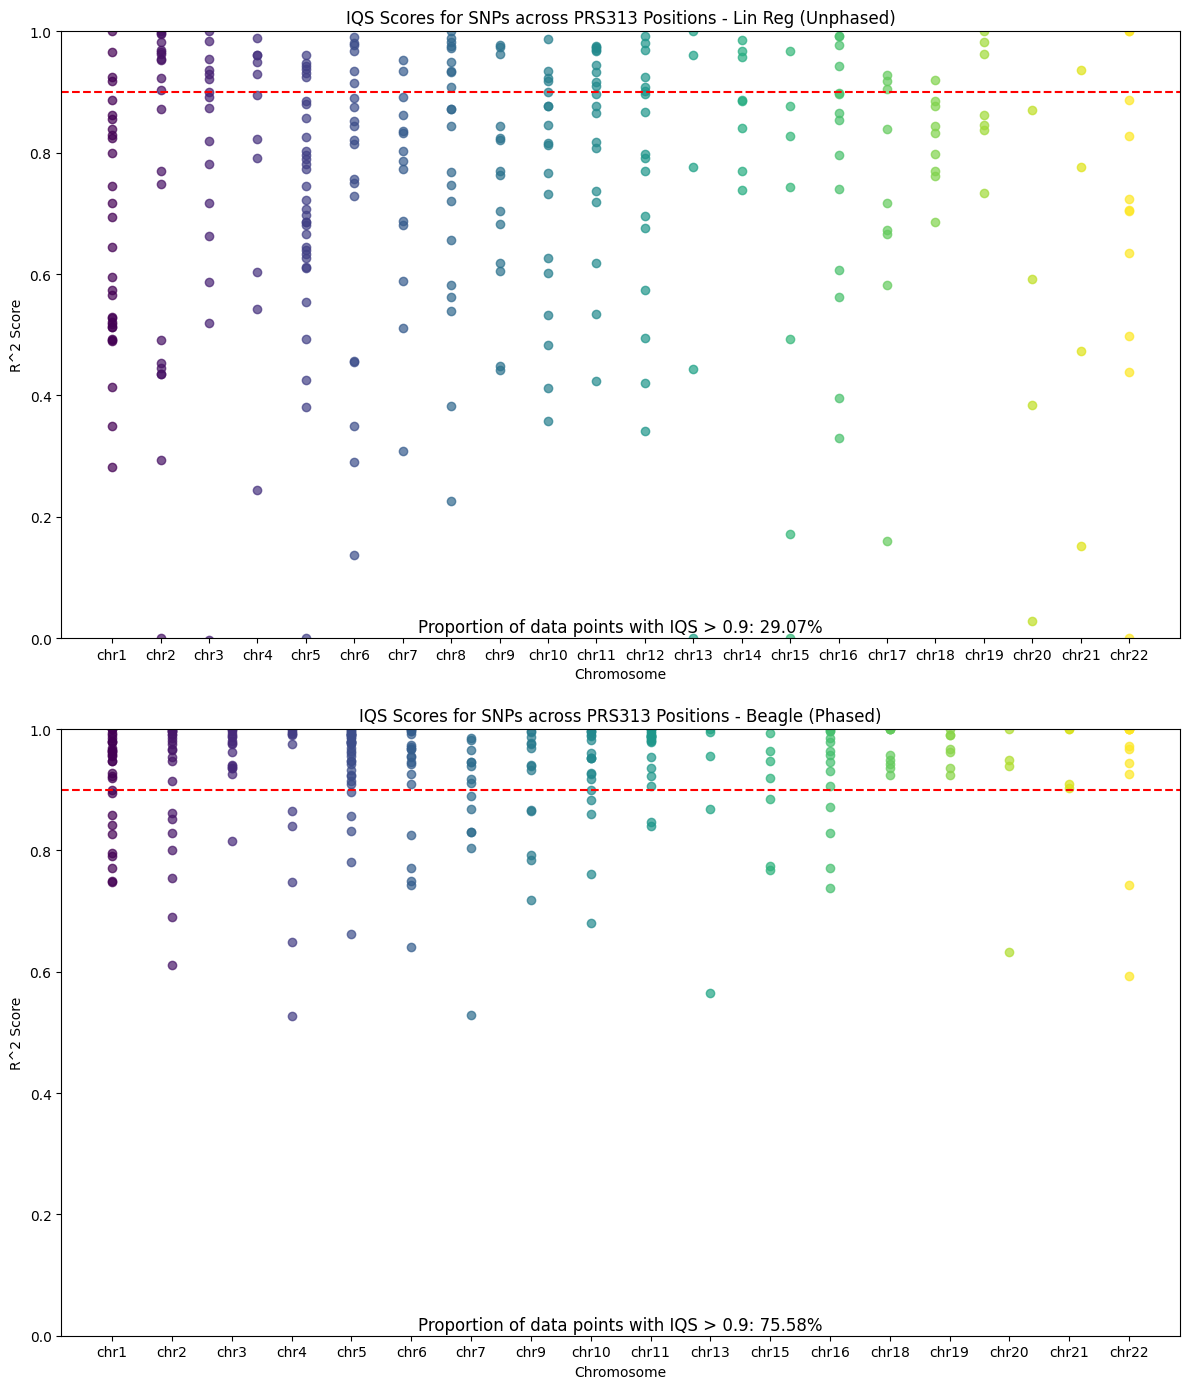

In [53]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from functools import partial

# Define a function to read and process CSV file
def read_and_process_csv(base_dir, chr_folder):
    csv_file = os.path.join(base_dir, chr_folder, f'individual_iqs_scores_{chr_folder}.csv')
    df = pd.read_csv(csv_file)
    df[['chromosome', 'position']] = df['SNP'].str.split('_', n=2, expand=True)[[0, 1]]
    df['position'] = pd.to_numeric(df['position'])
    return df

# Define a function to plot data
def plot_data(ax, cmap, i, df, chr_folder, label_prefix):
    df['x'] = i
    main_data = df[(df['IQS Score'] >= -1) & (df['IQS Score'] <= 1)]
    outliers = df[(df['IQS Score'] < -1) | (df['IQS Score'] > 1)]

    # Plot main data points
    ax.scatter(main_data['x'], main_data['IQS Score'], label=f"{label_prefix} {chr_folder}", color=cmap(i), alpha=0.7)

    # Highlight outliers
    offset_x = 0  # Adjust the x offset for the annotation
    offset_y = -0.075  # Adjust the y offset for the annotation
    for _, outlier in outliers.iterrows():
        y_position = -1 if outlier['IQS Score'] < -1 else 1
        ax.scatter(outlier['x'], y_position, color=cmap(i), edgecolor='red', s=100, linewidth=2, facecolor='none')
        ax.text(outlier['x'] + offset_x, y_position + offset_y * (1 if y_position == 1 else -1), f"{outlier['IQS Score']:.2f}", color='red', fontsize=8, ha='center', va='center')

    return (df['IQS Score'] > 0.9).sum(), len(df)

# Define a function to create the plot
def create_plot_iqs(base_dir, model_name, ax, label_prefix):
    chr_folders = sorted(
        (folder for folder in os.listdir(base_dir) if folder.startswith('chr')),
        key=lambda x: int(x[3:])
    )
    
    cmap = plt.get_cmap('viridis', len(chr_folders))

    process_folder = partial(read_and_process_csv, base_dir)
    results = [
        plot_data(ax, cmap, i, process_folder(chr_folder), chr_folder, label_prefix) 
        for i, chr_folder in enumerate(chr_folders)
    ]

    data_points_above_threshold, total_data_points = map(sum, zip(*results))
    proportion = data_points_above_threshold / total_data_points

    ax.axhline(y=0.9, color='red', linestyle='--', linewidth=1.5)
    ax.set_title(f'IQS Scores for SNPs across PRS313 Positions - {model_name}')
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('R^2 Score')
    ax.set_xticks(range(len(chr_folders)))
    ax.set_xticklabels(chr_folders)
    ax.set_ylim(0, 1)
    ax.text(0.5, 0.01, f'Proportion of data points with IQS > 0.9: {proportion:.2%}', transform=ax.transAxes, fontsize=12, ha='center')

# Define a function to plot the comparison
def plot_comparison(base_dir_1, model_name_1, base_dir_2, model_name_2):
    fig, axs = plt.subplots(2, 1, figsize=(12, 14))

    create_plot_iqs(base_dir_1, model_name_1, axs[0], 'Model 1')
    create_plot_iqs(base_dir_2, model_name_2, axs[1], 'Model 2')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.15)  # Adjust this value to increase spacing between the plots
    plt.show()

# Define the base directory paths and model names
base_dir_1 = "../../../Data/model_results_unphased_all_PRS/linear_regression/csv_files"
model_name_1 = "Lin Reg (Unphased)"

base_dir_2 = "../../../Data/model_results_unphased_all_PRS/beagle/csv_files"
model_name_2 = "Beagle (Phased)"

# Create the comparison plot
plot_comparison(base_dir_1, model_name_1, base_dir_2, model_name_2)


# Unphased Data

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Set the path to the folder containing the result files
folder_path = "../../../Data/model_results_unphased_all_PRS/linear_regression/csv_files"

# Concatenate all the dataframes into a single dataframe
combined_df = pd.read_csv(folder_path + "performance_metrics.csv")

combined_df = combined_df.dropna()

# Drop the Chromosome Column
combined_df = combined_df.drop(columns='Chromosome')

# Calculate summary statistics
summary_stats = combined_df.describe()

print(summary_stats)

# Extract the median values and standard deviations
medians = summary_stats.loc['50%'].values
std_devs = summary_stats.loc['std'].values

# Create a list of metric names
metrics = ['Accuracy', 'Precision', 'Recall', 'False Positive Rate', 'AUC ROC', 'R2', "IQS"]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Create a bar plot of the medians with error bars
x = range(len(metrics))
ax.bar(x, medians, yerr=std_devs, align='center', alpha=0.5, ecolor='black', capsize=10)

# Set the x-tick labels to the metric names
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')

# Set the labels and title
ax.set_ylabel('Value')
ax.set_title('Median Imputation Metrics with Standard Deviation Across All 250 Unknown PRS313 SNPs', fontsize=16)


# Display the values of median and standard deviation on the bars
for i, v in enumerate(medians):
    ax.text(i, v + std_devs[i] + 0.01, f"Median: {v:.3f}\nStd: {std_devs[i]:.3f}", ha='center', fontsize=8)

# Adjust the layout
fig.tight_layout()

# Display the plot
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../../../Data/model_results_unphased_all_PRS/linear_regression/csv_filesperformance_metrics.csv'

/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_66740/2417319771.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(chr_folders))


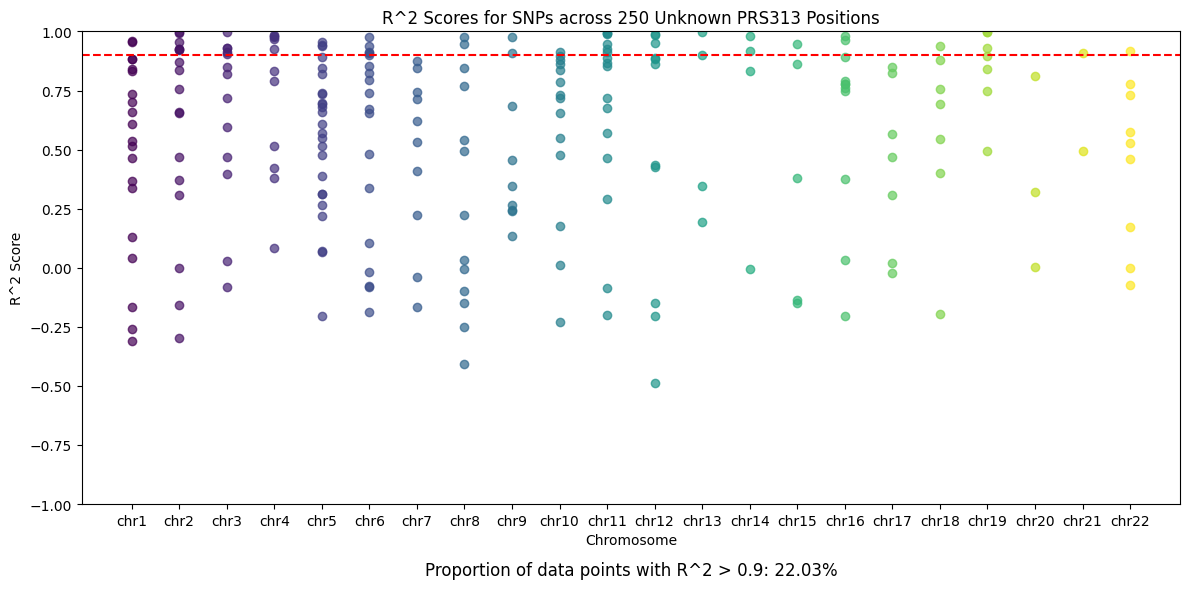

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Specify the base directory path
base_dir = '../../Data/model_results_unphased/logistic_regression/csv_files/'

# Get the list of chromosome folders
chr_folders = [folder for folder in os.listdir(base_dir) if folder.startswith('chr')]

# Sort the chromosome folders
chr_folders.sort(key=lambda x: int(x[3:]))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Define a color map
cmap = plt.cm.get_cmap('viridis', len(chr_folders))

total_data_points = 0
data_points_above_threshold = 0

# Iterate over each chromosome folder
for i, chr_folder in enumerate(chr_folders):
    # Get the CSV file path
    csv_file = os.path.join(base_dir, chr_folder, 'individual_r2_scores_' + chr_folder + '.csv')
    
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Extract the chromosome and SNP position from the SNP column
    df[['chromosome', 'position']] = df['SNP'].str.split('_', n=2, expand=True)[[0, 1]]
    
    # Convert position to numeric
    df['position'] = pd.to_numeric(df['position'])
    
    # Assign x-coordinates based on the chromosome number
    df['x'] = i
    
    # Create a scatter plot for the current chromosome
    ax.scatter(df['x'], df['R2 Score'], label=chr_folder, color=cmap(i), alpha=0.7)
    
    # Calculate the number of data points above the threshold for the current chromosome
    data_points_above_threshold += (df['R2 Score'] > 0.9).sum()
    total_data_points += len(df)

# Calculate the proportion of data points above the threshold
proportion = data_points_above_threshold / total_data_points

# Add a dashed line at 0.9
ax.axhline(y=0.9, color='red', linestyle='--', linewidth=1.5)

# Set the title and labels
ax.set_title('R^2 Scores for SNPs across 250 Unknown PRS313 Positions')
ax.set_xlabel('Chromosome')
ax.set_ylabel('R^2 Score')

# Set the x-tick labels to the chromosome numbers
ax.set_xticks(range(len(chr_folders)))
ax.set_xticklabels(chr_folders)

# Set the y-axis limits
ax.set_ylim(-1, 1)

# Add the proportion annotation at the bottom
ax.text(0.5, -0.15, f'Proportion of data points with R^2 > 0.9: {proportion:.2%}', transform=ax.transAxes, fontsize=12, ha='center')

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Adjust the bottom margin to make room for the text
plt.subplots_adjust(bottom=0.15)

# Display the plot
plt.show()

# All PRS313 SNPs Unphased

       Accuracy  Precision    Recall  False Positive Rate   AUC ROC  R2 Score  \
count  2.000000   2.000000  2.000000             2.000000  2.000000  2.000000   
mean   0.881390   0.884472  0.882120             0.128721  0.951866  0.397149   
std    0.025526   0.052342  0.053324             0.010173  0.019429  0.184963   
min    0.863340   0.847460  0.844414             0.121528  0.938128  0.266360   
25%    0.872365   0.865966  0.863267             0.125125  0.944997  0.331754   
50%    0.881390   0.884472  0.882120             0.128721  0.951866  0.397149   
75%    0.890414   0.902977  0.900973             0.132318  0.958735  0.462543   
max    0.899439   0.921483  0.919826             0.135915  0.965605  0.527937   

       IQS Score  
count   2.000000  
mean    0.753271  
std     0.042601  
min     0.723147  
25%     0.738209  
50%     0.753271  
75%     0.768333  
max     0.783394  


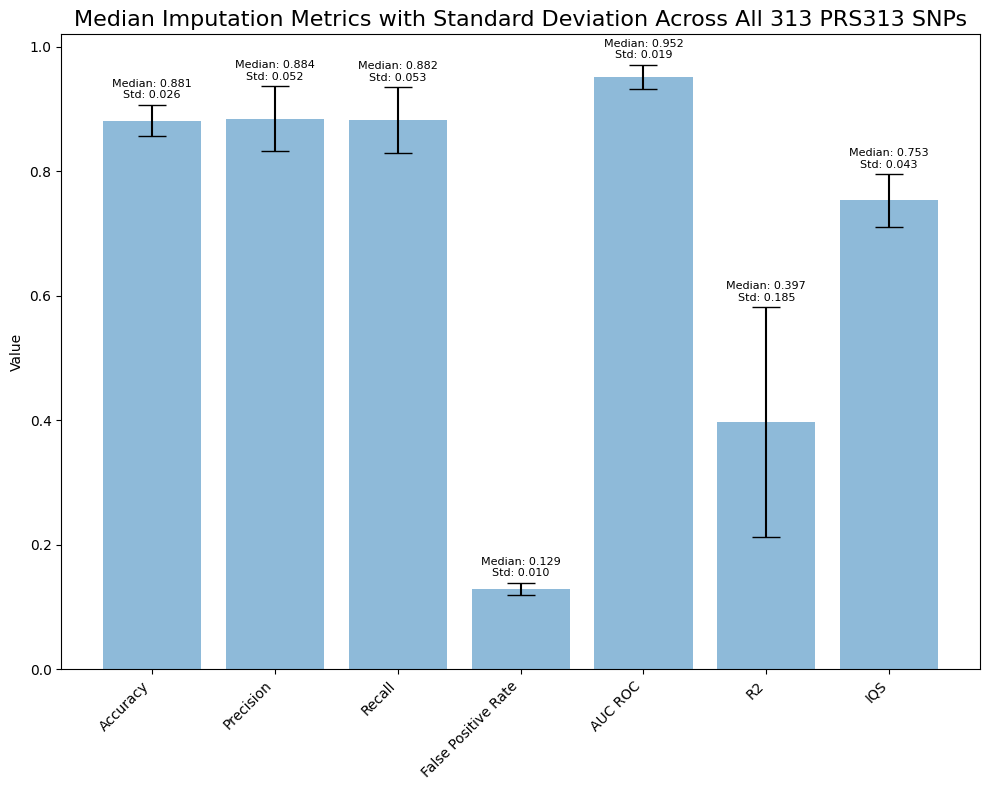

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Set the path to the folder containing the result files
folder_path = "../../Data/model_results_unphased_all_PRS/logistic_regression/csv_files/"

# Concatenate all the dataframes into a single dataframe
combined_df = pd.read_csv(folder_path + "performance_metrics.csv")

combined_df = combined_df.dropna()

# Drop the Chromosome Column
combined_df = combined_df.drop(columns='Chromosome')

# Calculate summary statistics
summary_stats = combined_df.describe()

print(summary_stats)

# Extract the median values and standard deviations
medians = summary_stats.loc['50%'].values
std_devs = summary_stats.loc['std'].values

# Create a list of metric names
metrics = ['Accuracy', 'Precision', 'Recall', 'False Positive Rate', 'AUC ROC', 'R2', "IQS"]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Create a bar plot of the medians with error bars
x = range(len(metrics))
ax.bar(x, medians, yerr=std_devs, align='center', alpha=0.5, ecolor='black', capsize=10)

# Set the x-tick labels to the metric names
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')

# Set the labels and title
ax.set_ylabel('Value')
ax.set_title('Median Imputation Metrics with Standard Deviation Across All 313 PRS313 SNPs', fontsize=16)

# Display the values of median and standard deviation on the bars
for i, v in enumerate(medians):
    ax.text(i, v + std_devs[i] + 0.01, f"Median: {v:.3f}\nStd: {std_devs[i]:.3f}", ha='center', fontsize=8)

# Adjust the layout
fig.tight_layout()

# Display the plot
plt.show()

/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_47403/4033810059.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(chr_folders))


30
51
67
78
112
132
146
167
181
199
218
235
240
248
255
269
278
287
294
298
302
313


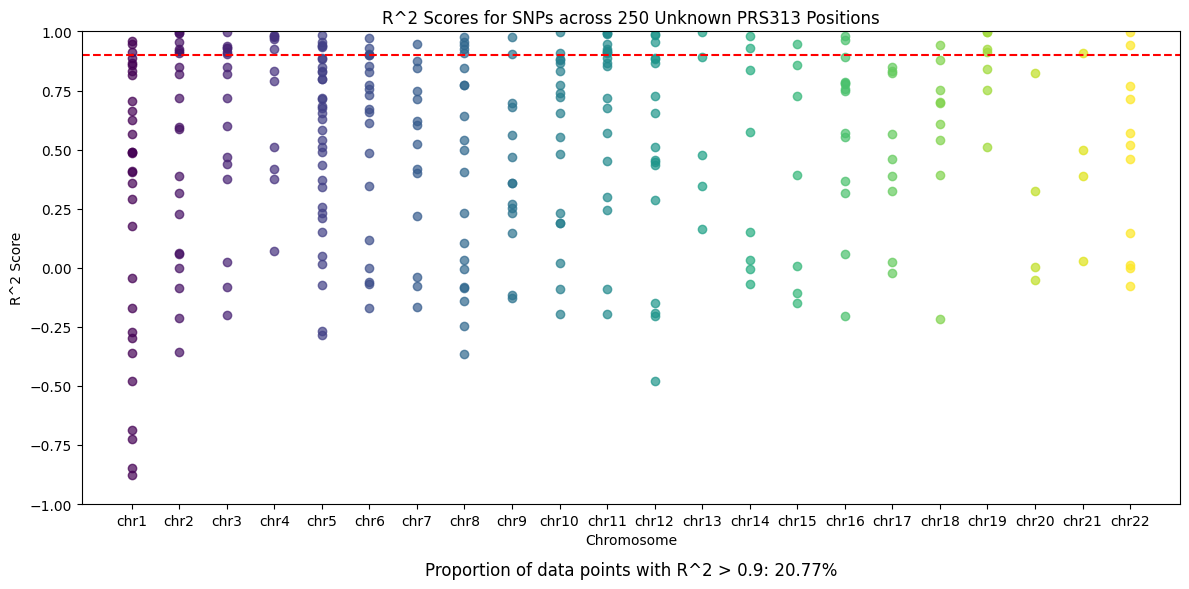

Total number of data points:  313


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Specify the base directory path
base_dir = '../../Data/model_results_unphased_all_PRS/logistic_regression/csv_files/'

# Get the list of chromosome folders
chr_folders = [folder for folder in os.listdir(base_dir) if folder.startswith('chr')]

# Sort the chromosome folders
chr_folders.sort(key=lambda x: int(x[3:]))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Define a color map
cmap = plt.cm.get_cmap('viridis', len(chr_folders))

total_data_points = 0
data_points_above_threshold = 0

# Iterate over each chromosome folder
for i, chr_folder in enumerate(chr_folders):
    # Get the CSV file path
    csv_file = os.path.join(base_dir, chr_folder, 'individual_r2_scores_' + chr_folder + '.csv')
    
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Extract the chromosome and SNP position from the SNP column
    df[['chromosome', 'position']] = df['SNP'].str.split('_', n=2, expand=True)[[0, 1]]
    
    # Convert position to numeric
    df['position'] = pd.to_numeric(df['position'])
    
    # Assign x-coordinates based on the chromosome number
    df['x'] = i
    
    # Create a scatter plot for the current chromosome
    ax.scatter(df['x'], df['R2 Score'], label=chr_folder, color=cmap(i), alpha=0.7)
    
    # Calculate the number of data points above the threshold for the current chromosome
    data_points_above_threshold += (df['R2 Score'] > 0.9).sum()
    total_data_points += len(df)
    print(total_data_points)

# Calculate the proportion of data points above the threshold
proportion = data_points_above_threshold / total_data_points

# Add a dashed line at 0.9
ax.axhline(y=0.9, color='red', linestyle='--', linewidth=1.5)

# Set the title and labels
ax.set_title('R^2 Scores for SNPs across 250 Unknown PRS313 Positions')
ax.set_xlabel('Chromosome')
ax.set_ylabel('R^2 Score')

# Set the x-tick labels to the chromosome numbers
ax.set_xticks(range(len(chr_folders)))
ax.set_xticklabels(chr_folders)

# Set the y-axis limits
ax.set_ylim(-1, 1)

# Add the proportion annotation at the bottom
ax.text(0.5, -0.15, f'Proportion of data points with R^2 > 0.9: {proportion:.2%}', transform=ax.transAxes, fontsize=12, ha='center')

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Adjust the bottom margin to make room for the text
plt.subplots_adjust(bottom=0.15)

# Display the plot
plt.show()

print("Total number of data points: ", total_data_points)

/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_47403/3610222703.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(chr_folders))


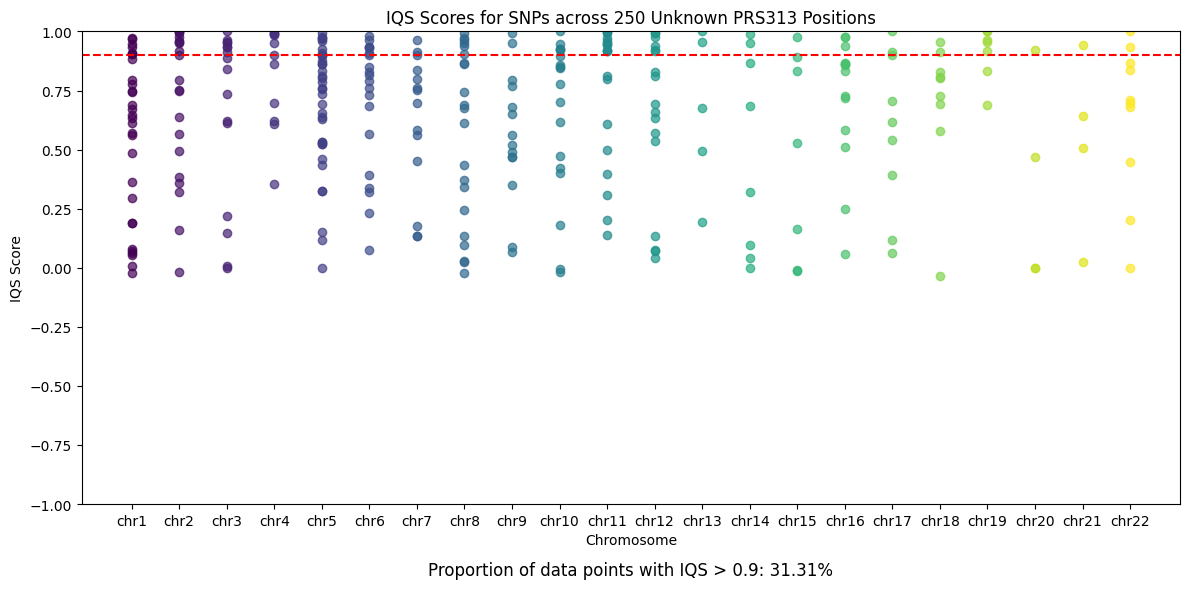

Total number of data points:  313


In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Specify the base directory path
base_dir = '../../Data/model_results_unphased_all_PRS/logistic_regression/csv_files/'

# Get the list of chromosome folders
chr_folders = [folder for folder in os.listdir(base_dir) if folder.startswith('chr')]

# Sort the chromosome folders
chr_folders.sort(key=lambda x: int(x[3:]))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Define a color map
cmap = plt.cm.get_cmap('viridis', len(chr_folders))

total_data_points = 0
data_points_above_threshold = 0

# Iterate over each chromosome folder
for i, chr_folder in enumerate(chr_folders):
    # Get the CSV file path
    csv_file = os.path.join(base_dir, chr_folder, 'individual_iqs_scores_' + chr_folder + '.csv')
    
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Extract the chromosome and SNP position from the SNP column
    df[['chromosome', 'position']] = df['SNP'].str.split('_', n=2, expand=True)[[0, 1]]
    
    # Convert position to numeric
    df['position'] = pd.to_numeric(df['position'])
    
    # Assign x-coordinates based on the chromosome number
    df['x'] = i
    
    # Create a scatter plot for the current chromosome
    ax.scatter(df['x'], df['IQS Score'], label=chr_folder, color=cmap(i), alpha=0.7)
    
    # Calculate the number of data points above the threshold for the current chromosome
    data_points_above_threshold += (df['IQS Score'] > 0.9).sum()
    total_data_points += len(df)

# Calculate the proportion of data points above the threshold
proportion = data_points_above_threshold / total_data_points

# Add a dashed line at 0.9
ax.axhline(y=0.9, color='red', linestyle='--', linewidth=1.5)

# Set the title and labels
ax.set_title('IQS Scores for SNPs across 250 Unknown PRS313 Positions')
ax.set_xlabel('Chromosome')
ax.set_ylabel('IQS Score')

# Set the x-tick labels to the chromosome numbers
ax.set_xticks(range(len(chr_folders)))
ax.set_xticklabels(chr_folders)

# Set the y-axis limits
ax.set_ylim(-1, 1)

# Add the proportion annotation at the bottom
ax.text(0.5, -0.15, f'Proportion of data points with IQS > 0.9: {proportion:.2%}', transform=ax.transAxes, fontsize=12, ha='center')

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Adjust the bottom margin to make room for the text
plt.subplots_adjust(bottom=0.15)

# Display the plot
plt.show()

print("Total number of data points: ", total_data_points)